In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import plot_crop_growth_results
from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## Analysis across runs

In [2]:
ga_parallel_results_folder = "ga_parallel_results"
pickled_results_folder     = "pickled_ga_results"
values_costs_folder        = "unique_values_costs_results"
input_disturbances_csv     = "io/inputs/hourly_prcp_rad_temp_iowa.csv"

## Convergence Analysis

Plot the best revenue over generations for each of the 10 GA runs.

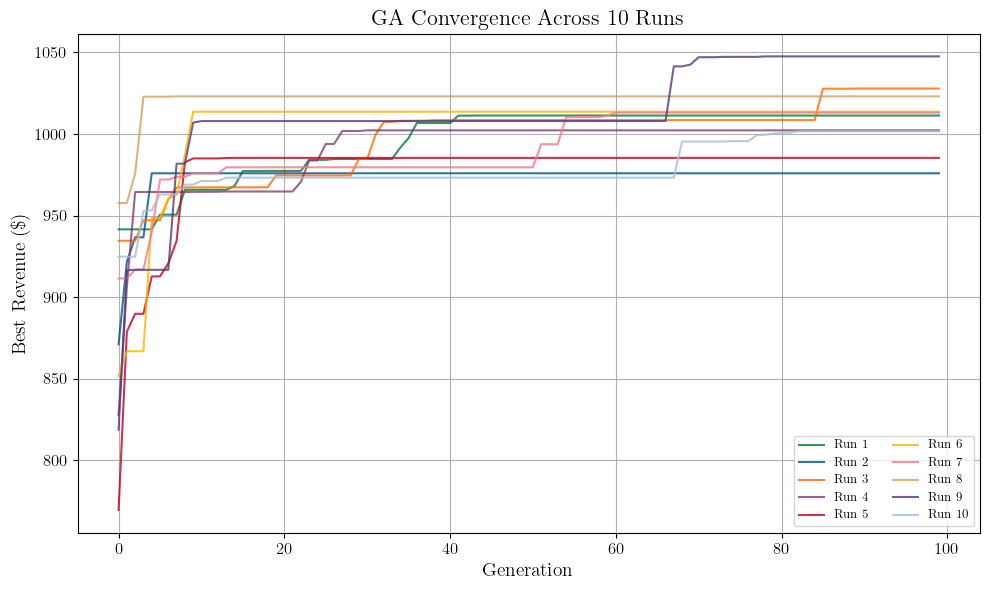


Final best revenue by run:
  Run 1: $1011.32
  Run 2: $975.91
  Run 3: $1027.88
  Run 4: $1002.24
  Run 5: $985.34
  Run 6: $1013.65
  Run 7: $1013.10
  Run 8: $1023.07
  Run 9: $1047.58
  Run 10: $1001.62


In [3]:
# Load pickled GA results and plot convergence
fig, ax = plt.subplots(figsize=(10, 6))

# Color palette for 10 runs (using color-blind friendly colors)
run_colors = [
    plotting_colors.vivid_green,
    plotting_colors.strong_blue,
    plotting_colors.vivid_orange,
    plotting_colors.strong_purple,
    plotting_colors.vivid_red,
    plotting_colors.vivid_yellow,
    plotting_colors.strong_purplish_pink,
    plotting_colors.grayish_yellow,
    plotting_colors.deep_purple,
    plotting_colors.very_light_blue,
]

for i in range(1, 11):
    pkl_path = os.path.join(
        ga_parallel_results_folder,
        pickled_results_folder,
        f"ga_parallel_result_{i}.pkl"
    )
    
    with open(pkl_path, 'rb') as f:
        ga_result = pickle.load(f)
    
    # Convert costs to revenues (negate)
    generations = range(len(ga_result.lowest_costs))
    revenues = [-c for c in ga_result.lowest_costs]
    
    ax.plot(generations, revenues, color=run_colors[i-1], linewidth=1.5, 
            alpha=0.8, label=f'Run {i}')

ax.set_xlabel('Generation')
ax.set_ylabel('Best Revenue (\\$)')
ax.set_title('GA Convergence Across 10 Runs')
ax.legend(loc='lower right', ncol=2, fontsize=9)

plt.tight_layout()
plt.savefig('ga_parallel_results/ga_convergence_all_runs.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final revenues for each run
print("\nFinal best revenue by run:")
for i in range(1, 11):
    pkl_path = os.path.join(
        ga_parallel_results_folder,
        pickled_results_folder,
        f"ga_parallel_result_{i}.pkl"
    )
    with open(pkl_path, 'rb') as f:
        ga_result = pickle.load(f)
    final_revenue = -ga_result.lowest_costs[-1]
    print(f"  Run {i}: ${final_revenue:.2f}")

## Growth analysis - Best in the final populations

In [4]:
# Set up Member attributes common to all runs
ga_params = GeneticAlgorithmParams()
carrying_capacities = ModelCarryingCapacities()
input_disturbances = ModelDisturbances.from_defaults(path=os.path.join(project_root, input_disturbances_csv))
growth_rates = ModelGrowthRates()
model_params = ModelParams(verbose=True)
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)
default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)
sensitivities = ModelSensitivities()

Analyzing best member from run 1...
Revenue: $1013.1263121151594 with inputs: IF=2656.2458212184, IA=0.8661910013, FF=1557.3534472355, FA=116.1102643818
Analyzing best member from run 2...
Revenue: $1053.8594159648862 with inputs: IF=1700.6663206792, IA=0.6109559322, FF=1476.7695666653, FA=126.4241617113
Analyzing best member from run 3...
Revenue: $999.7956239295614 with inputs: IF=1942.4448800872, IA=0.7083271567, FF=1155.2160848173, FA=99.8934255557
Analyzing best member from run 4...
Revenue: $1039.913439046738 with inputs: IF=1993.5322592243, IA=0.5601525054, FF=1790.0691355929, FA=143.0509296429
Analyzing best member from run 5...
Revenue: $925.4185552310146 with inputs: IF=2589.8367175755, IA=0.0932409434, FF=1894.8319302206, FA=109.7084146585
Analyzing best member from run 6...
Revenue: $850.823265358951 with inputs: IF=1333.4492407454, IA=1.0735513083, FF=323.9992313666, FA=44.9444148992
Analyzing best member from run 7...
Revenue: $894.8574547494183 with inputs: IF=1083.59658

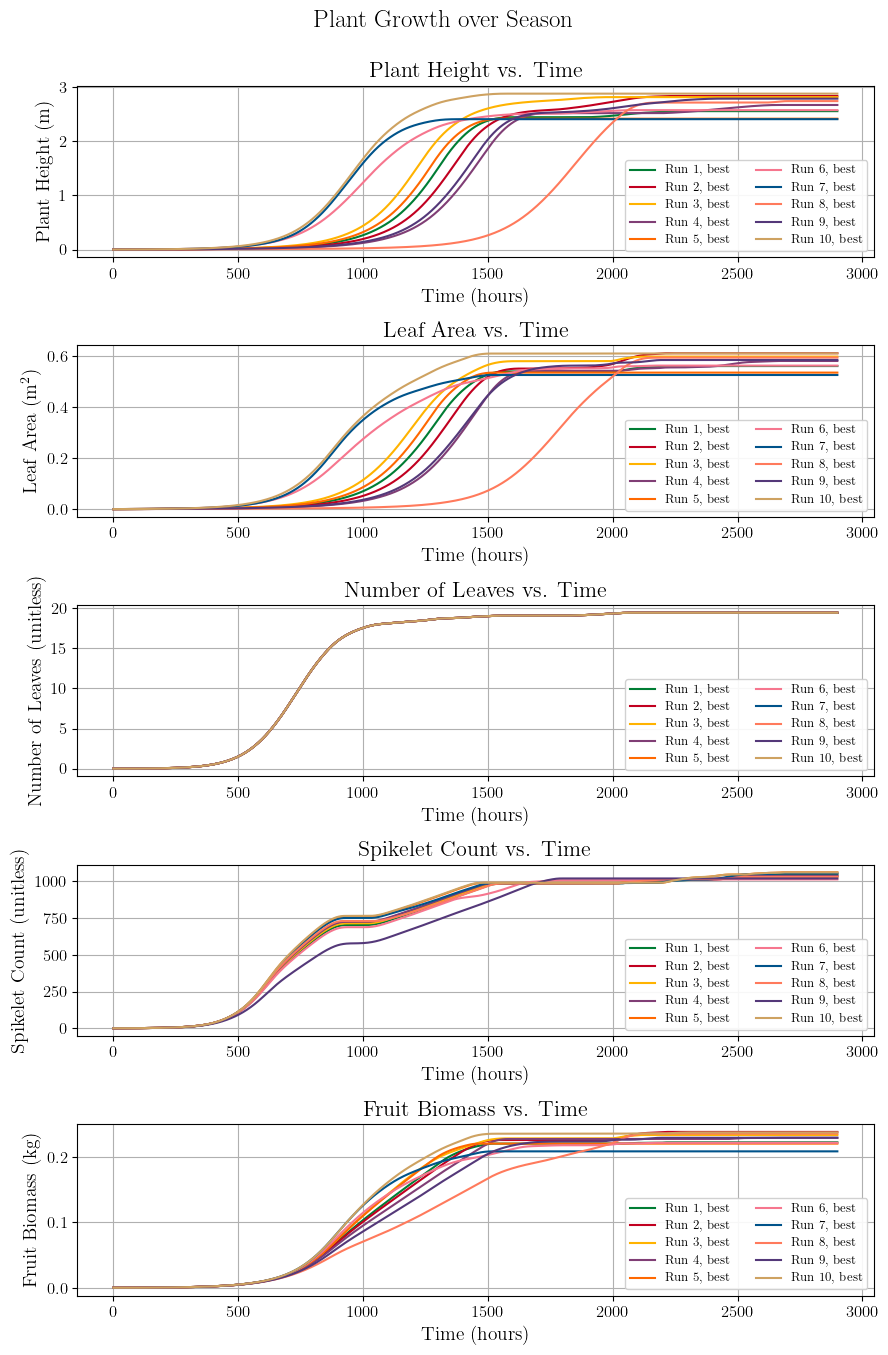

In [5]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing best member from run {i}...")

    # Load the best member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    best_index = np.argmax(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[best_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[best_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, best')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

## Growth analysis - Worst in the final populations

Analyzing worst member from run 1...
Revenue: $-8080.318892300439 with inputs: IF=295.0552922219, IA=6.7912755844, FF=77.6768844037, FA=340.5247740584
Analyzing worst member from run 2...
Revenue: $-15555.20257060772 with inputs: IF=1416.6021695688, IA=2.1568369492, FF=71.1734080728, FA=617.4122720119
Analyzing worst member from run 3...
Revenue: $-22623.386509852447 with inputs: IF=1048.1472502475, IA=8.8273033487, FF=45.9606327023, FA=574.3813836566
Analyzing worst member from run 4...
Revenue: $-21449.04225948975 with inputs: IF=2595.8925706575, IA=6.4083714791, FF=26.2960948147, FA=323.0769232716
Analyzing worst member from run 5...
Revenue: $-4925.5833373371715 with inputs: IF=2153.683832295, IA=7.085889064, FF=258.7433193164, FA=664.7986563363
Analyzing worst member from run 6...
Revenue: $-7668.783227668415 with inputs: IF=1227.3296067682, IA=7.0324227131, FF=150.7551726555, FA=621.1112364193
Analyzing worst member from run 7...
Revenue: $-10300.731152240625 with inputs: IF=1038

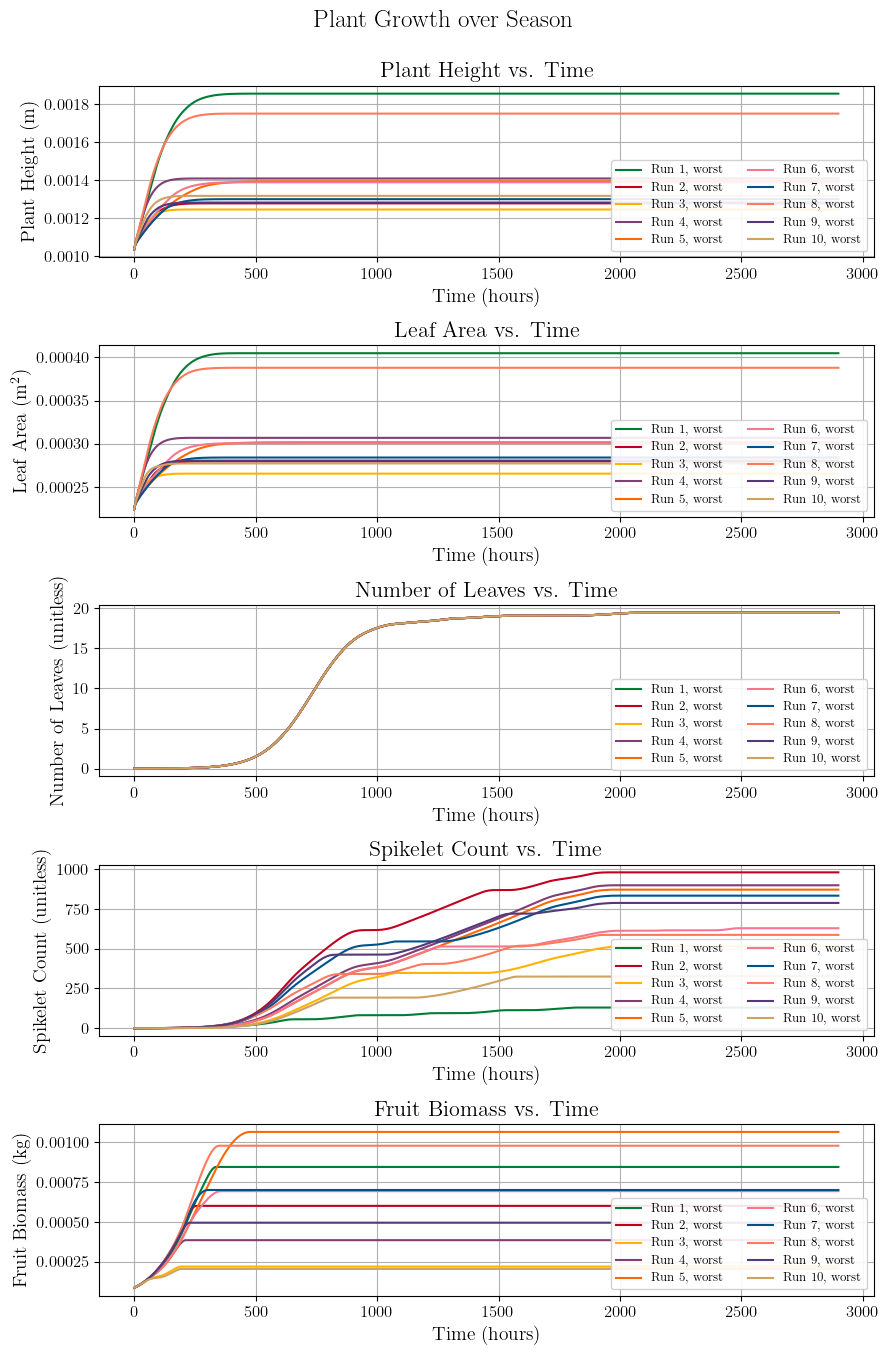

In [6]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing worst member from run {i}...")

    # Load the worst member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    worst_index = np.argmin(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[worst_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[worst_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, worst')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)